# Projet 6: Classifiez automatiquement des biens de consommation

## Analyse visuelle - Computer Vision.

### Sommaire

- <a href="#C2">Importation du jeu de données</a>

- <a href="#C3">prétraitement des images</a>

- <a href="#C4">Descripteurs: SIFT - ORB</a>

- <a href="#C5">Classification des images via SIFT</a>

    - <a href="#C51">Créations des descripteurs de chaque image</a>

    - <a href="#C52">Création des clusters de descripteurs </a>

    - <a href="#C53">Création des features des images </a>
    
    - <a href="#C54">Réductions de dimension</a>

    - <a href="#C55">Analyse visuelle : affichage T-SNE selon catégories d'images</a>

    - <a href="#C56">Analyse mesures : similarité entre catégories et clusters</a>

- <a href="#C6">Classification des images via ORB</a>

    - <a href="#C61">Créations des descripteurs de chaque image</a>

    - <a href="#C62">Création des clusters de descripteurs </a>

    - <a href="#C63">Création des features des images </a>
    
    - <a href="#C64">Réductions de dimension</a>

    - <a href="#C65">Analyse visuelle : affichage T-SNE selon catégories d'images</a>

    - <a href="#C66">Analyse mesures : similarité entre catégories et clusters</a>

- <a href="#C7">CNN Transfert Learning</a>

- <a href="#C8">Classification des images via CNN VGG16</a>

- <a href="#C81">Classification des images via CNN VGG19</a>

- <a href="#C9">Classification des images via CNN ResNet50</a>

- <a href="#C10">Classification des images via CNN InceptionV3</a>


# <a name="C2">Importation du jeu de données</a>

## Libraries

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.image import imread

import IPython
from IPython.display import display
from IPython.display import Image

from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL
import PIL

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image


import time
import os

import cv2 #opencv pour SIFT, surf & orb

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
list_photos = [file for file in os.listdir('Images')]
print(len(list_photos))
list_photos[0]

1050


'3dfd14b667357e26ff6d66761cdc203f.jpg'

In [3]:
path = 'Images/'

In [5]:
data = pd.read_csv('data.csv')

In [6]:
data.head(1)

category                                        description  \
0  Home Furnishing   Key Features of Elegance Polyester Multicolor ...   

                                  image  
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg

In [7]:
group_category = data.groupby('category')['image']

In [8]:
group_category

In [9]:
list(group_category)[0]

('Baby Care ',
 1       7b72c92c2f6c40268628ec5f14c6d590.jpg
 2       64d5d4a258243731dc7bbb1eef49ad74.jpg
 40      90e56526f4c5892beac49f262b85150a.jpg
 42      5325213d84c80ad310b6e4b37a1ac824.jpg
 63      f4e7f269319ba9cf5507a9e2febacbf5.jpg
                         ...                 
 1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
 1046    fd6cbcc22efb6b761bd564c28928483c.jpg
 1047    5912e037d12774bb73a2048f35a00009.jpg
 1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
 1049    f2f027ad6a6df617c9f125173da71e44.jpg
 Name: image, Length: 150, dtype: object)

0
Baby Care 


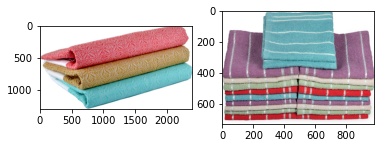

1
Beauty and Personal Care 


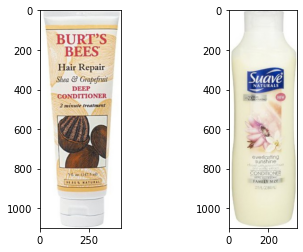

2
Computers 


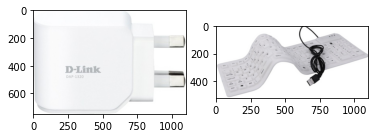

3
Home Decor & Festive Needs 


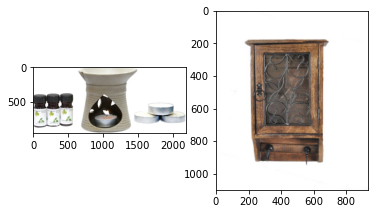

4
Home Furnishing 


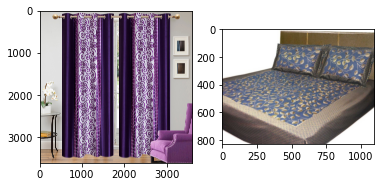

5
Kitchen & Dining 


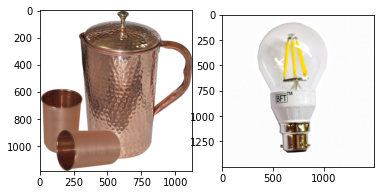

6
Watches 


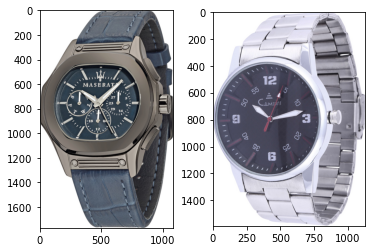

In [99]:
for i, seq in enumerate(group_category):
    categ, img = seq
    print(i)
    print(categ)
    
    for j in range(1,3):
        file=str(img[j-1:j].values)[2:-2]
      
        plt.subplot(1,2,j)
        filename = path+file
        image = imread(filename) # matplotlib method to read images
        plt.imshow(image)

    plt.show()

# <a name="C3">Prétraitement de données textuelles</a>

In [13]:
def resize_sq_fill_image(img, sq_size=224, fill_col=(255,255,255),
                 interpolation=Image_PIL.ANTIALIAS):
    '''
    this function takes an image, resizes the image and fills the non existing space
    with custom color

    Argumants:
        img: image in np or PIL format
    
        sq_size: size request
    
        fill_col: fill color request
    
    returns:
        new_img: image resized with fill color
    '''    
    # can be PIL.Image.Image or np.array
    #if type(img) == np.ndarray:
    #    img = Image_PIL.fromarray(img)
    #elif type(img) == PIL.Image.Image:
    #    pass
    #else:
    #    print("ERROR: image format unknown, please give np.array or PIL.Image.Image")
    # PIL.Image.Image format from here

    w, h = img.size
    if h != w:
        dif = h if h > w else w
        new_img = Image_PIL.new('RGB', (dif, dif), fill_col)
        new_img.paste(img, (int((dif - w) / 2), int((dif - h) / 2)))
        img = new_img
    
    # Change format to np.array and resize with cv2
    new_img = cv2.resize(np.asarray(img), (sq_size, sq_size), interpolation)
    return np.array(new_img)

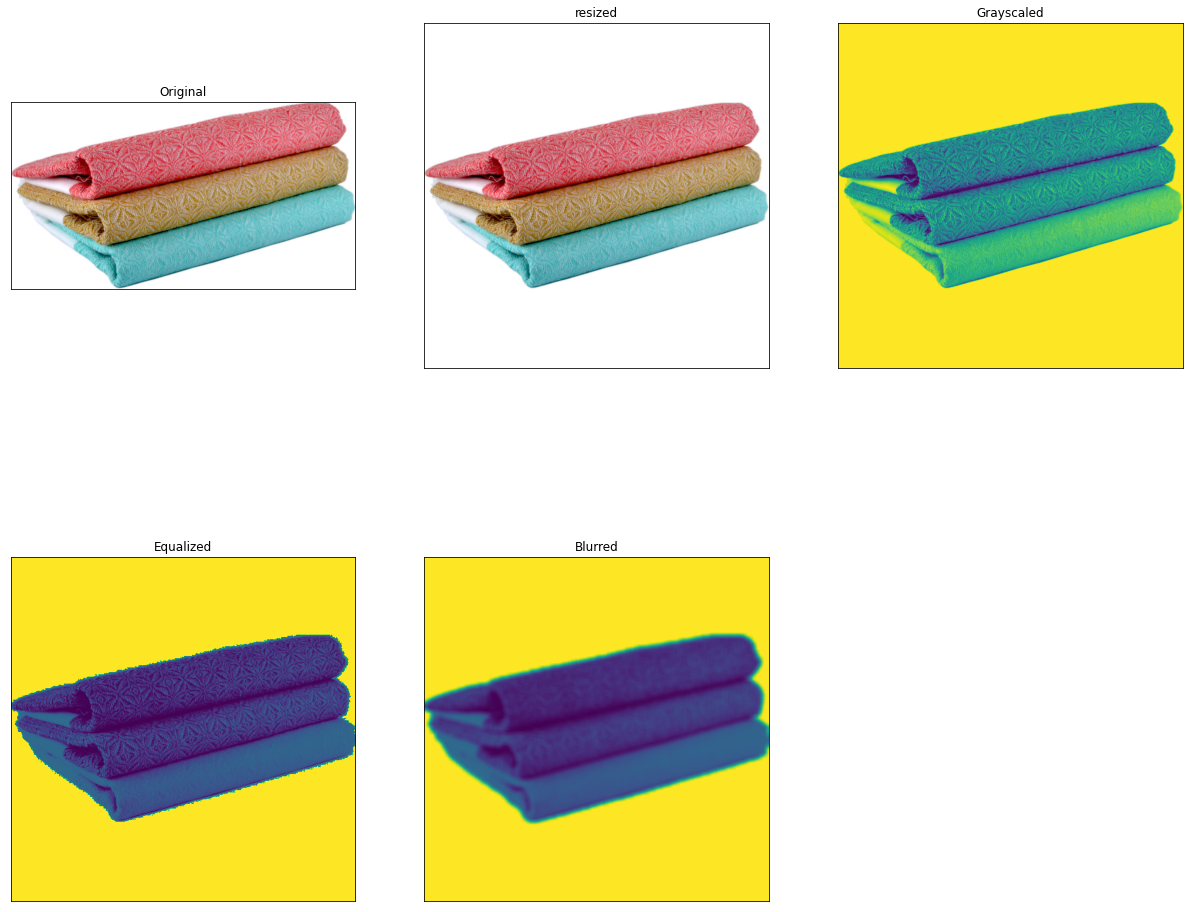

In [98]:
#img = cv2.imread(path+data['image'][data['image'].index==10].values[0])
img_path = path+data['image'][data['image'].index==1].values[0]
img = image.load_img(img_path)#, target_size=(224, 224))


img_resize = resize_sq_fill_image(img, sq_size=600)
gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
hist = cv2.equalizeHist(gray)
blur = cv2.blur(hist,(10,10))

plt.figure(figsize=(21, 18))
plt.subplot(231),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(232),plt.imshow(img_resize),plt.title('resized')
plt.xticks([]), plt.yticks([])
plt.subplot(233),plt.imshow(gray),plt.title('Grayscaled')
plt.xticks([]), plt.yticks([])
plt.subplot(234),plt.imshow(hist),plt.title('Equalized')
plt.xticks([]), plt.yticks([])
plt.subplot(235),plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

# <a name="C4">Descripteurs: SIFT - ORB</a>

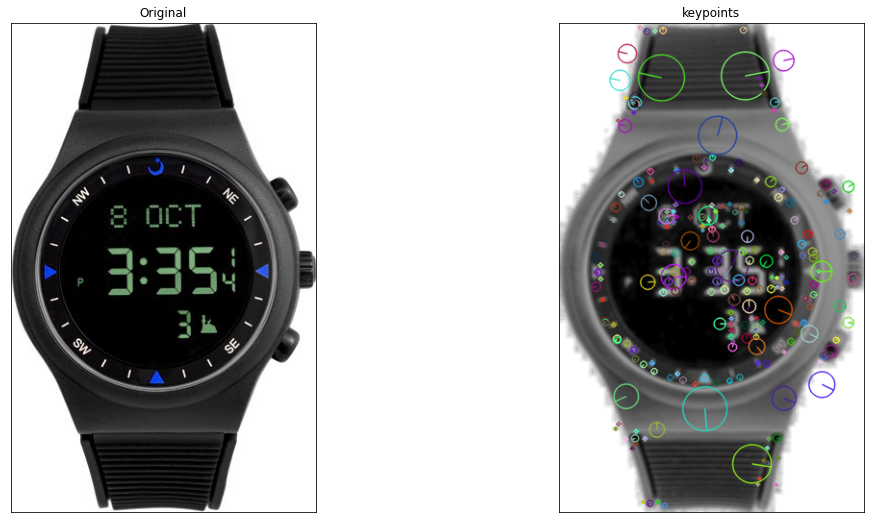

SIFT Descriptors :  (271, 128)

[[ 75.   9.   5. ...   3.   1.  45.]
 [ 81.  41.   0. ...   0.   0.  12.]
 [  3.   3.   3. ...   0.   4.  10.]
 ...
 [  0. 126.  61. ...   0.   0.   0.]
 [  0.   0.  13. ...   0.   0.   0.]
 [  1.   0.  12. ...   0.   0.   0.]]


In [104]:
img = cv2.imread(path+data['image'][data['image'].index==8].values[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hist = cv2.equalizeHist(gray)
blur = cv2.blur(hist,(5,5))

#keypoints SIFT
sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(blur,None)

img2 = cv2.drawKeypoints(blur, keypoints_1, blur, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(18, 9))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2),plt.title('keypoints')
plt.xticks([]), plt.yticks([])
plt.show()
print("SIFT Descriptors : ", descriptors_1.shape)
print()
print(descriptors_1)

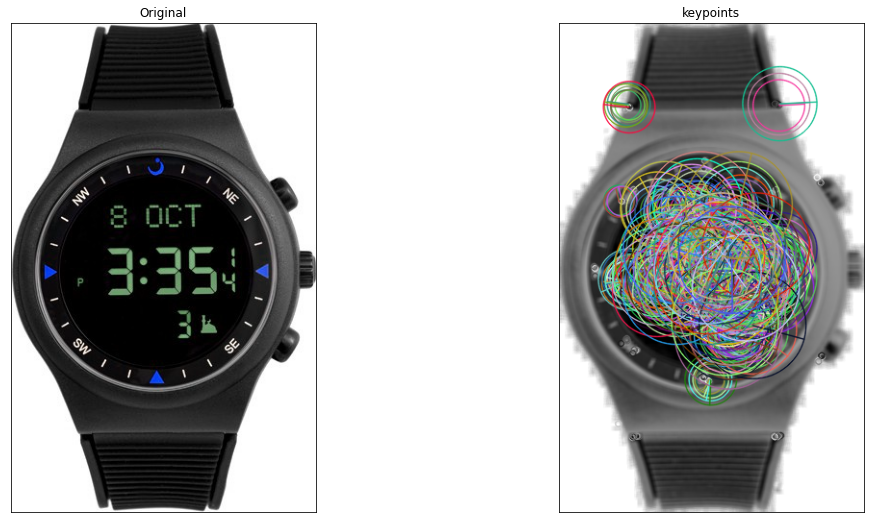

ORB Descriptors :  (500, 32)

[[248 172 156 ...  72 206  42]
 [ 96 170 154 ... 200 194  41]
 [ 84 241 188 ... 243 141  83]
 ...
 [ 70 158 220 ... 193 133  49]
 [189  93  84 ... 187  72  48]
 [ 65 164 157 ... 104  83  10]]


In [112]:
#keypoints ORB
orb = cv2.ORB_create()
keypoints_1, descriptors_1 = orb.detectAndCompute(blur,None)

img2 = cv2.drawKeypoints(blur, keypoints_1, blur, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(18, 9))
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2),plt.title('keypoints')
plt.xticks([]), plt.yticks([])
plt.show()
print("ORB Descriptors : ", descriptors_1.shape)
print()
print(descriptors_1)

# <a name="C5">Classification des images via SIFT</a> 

##  <a name="C51">Créations des descripteurs de chaque image</a>  
* Pour chaque image passage en gris, equalisation et adoucissement (smoothing blur)
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [27]:
path+data['image'][data['image'].index==0].values[0]

'Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'

In [28]:
# identification of key points and associated descriptors

sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create()

for image_num in range(len(list_photos)) :
    if image_num%50 == 0 : print(image_num)
    img = cv2.imread(path+data['image'][data['image'].index==image_num].values[0]) # cv2 read the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# convert in gray
    hist = cv2.equalizeHist(gray)  # equalize image histogram
    blur = cv2.blur(hist,(5,5))  # image smoothing with blur function
    kp, des = sift.detectAndCompute(blur, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000

Nombre de descripteurs :  (3538001, 128)
temps de traitement SIFT descriptor :           323.84 secondes


##  <a name="C52">Création des clusters de descripteurs</a>  
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [29]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  1881
Création de 1881 clusters de descripteurs ...
temps de traitement kmeans :            55.60 secondes


##  <a name="C53"> Création des features des images</a>
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [30]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0 #/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%50 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
temps de création histogrammes :            14.32 secondes


In [31]:
im_features.shape

(1050, 1881)

##  <a name="C54"> Réductions de dimension</a>

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [32]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 1881)
Dimensions dataset après réduction PCA :  (1050, 54)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [33]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category"]
print(df_tsne.shape)

(1050, 3)


##  <a name="C55">Analyse visuelle : affichage T-SNE selon catégories d'images</a> 

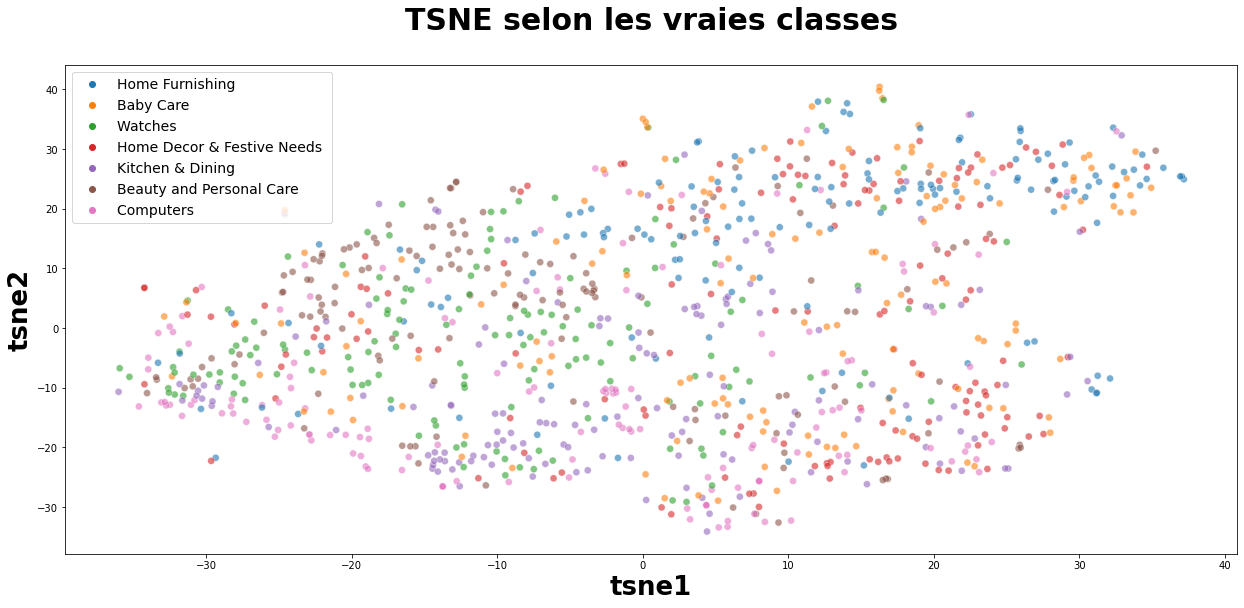

In [34]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

##  <a name="C56">Analyse mesures : similarité entre catégories et clusters</a> 

###  Création de clusters à partir du T-SNE

In [35]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI reste faible

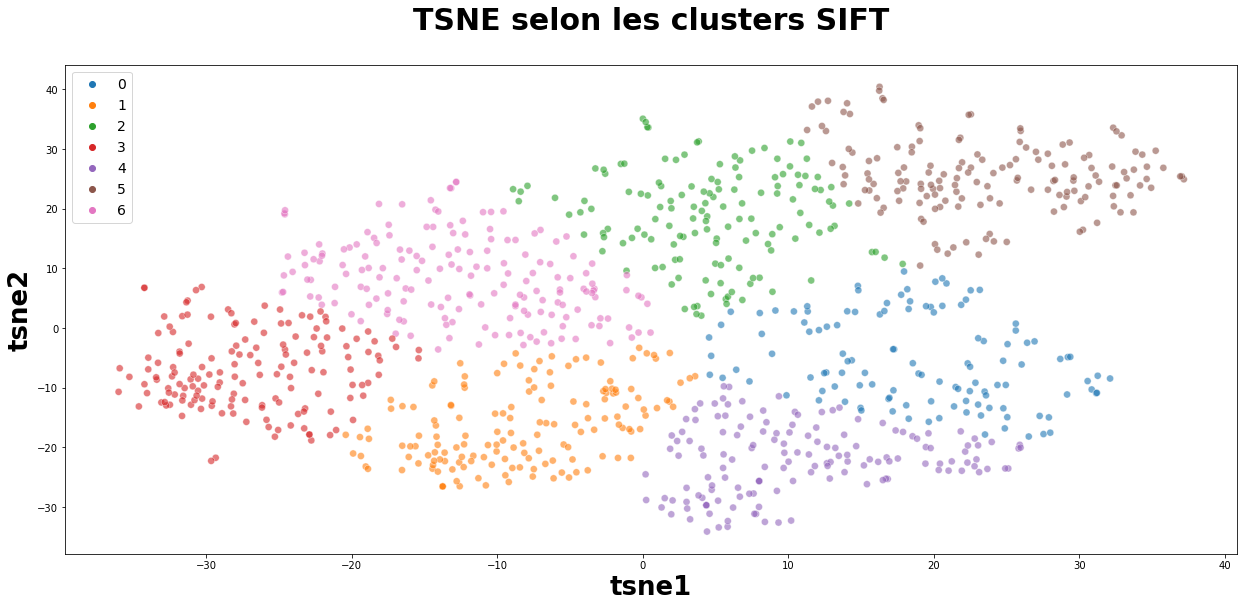

ARI SIFT:  0.0767


In [36]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters SIFT', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI SIFT: ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

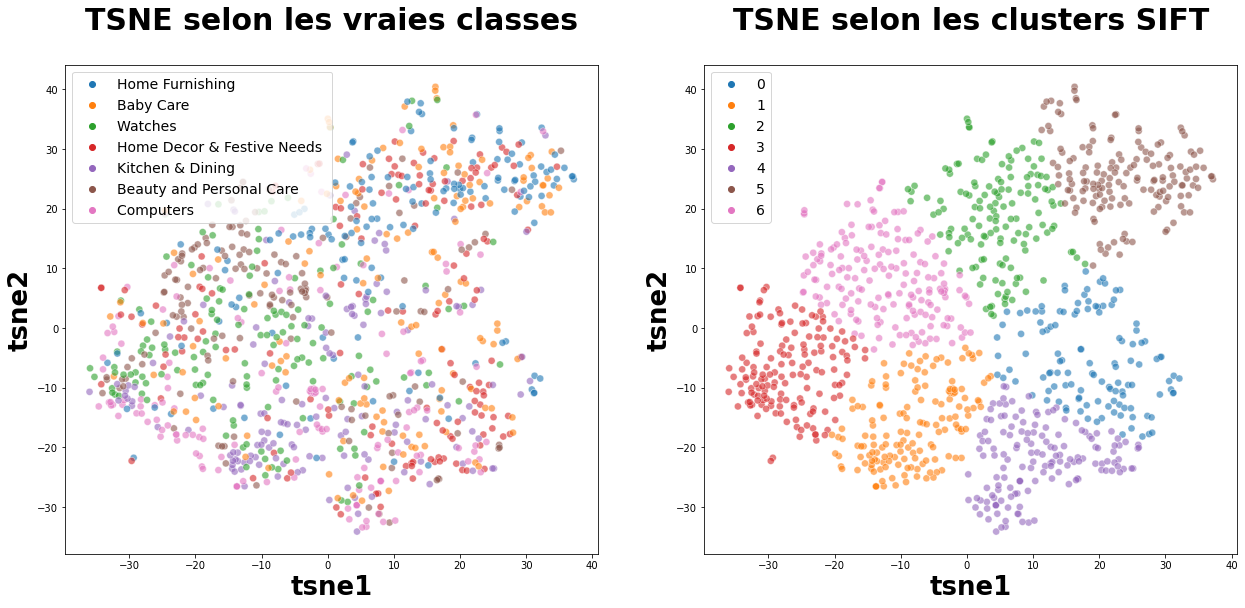

ARI SIFT:  0.0767


In [37]:
plt.figure(figsize=(21,9))

plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters SIFT', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI SIFT: ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

# <a name="C6">Classification des images via ORB</a> 

##  <a name="C61">Créations des descripteurs de chaque image</a>  
* Pour chaque image passage en gris, equalisation et adoucissement (smoothing blur)
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [38]:
# identification of key points and associated descriptors

orb_keypoints = []
temps1=time.time()
orb = cv2.ORB_create()

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    img = cv2.imread(path+data['image'][data['image'].index==image_num].values[0]) # cv2 read the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# convert in gray
    hist = cv2.equalizeHist(gray)  # equalize image histogram
    blur = cv2.blur(hist,(5,5))  # image smoothing with blur function
    kp, des = orb.detectAndCompute(blur, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (511283, 32)
temps de traitement ORB descriptor :            34.73 secondes


##  <a name="C62">Création des clusters de descripteurs</a>  
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [39]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  715
Création de 715 clusters de descripteurs ...
temps de traitement kmeans :             3.36 secondes


##  <a name="C63"> Création des features des images</a>
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [40]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%50 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
temps de création histogrammes :             4.57 secondes


##  <a name="C64"> Réductions de dimension</a>

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [41]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 715)
Dimensions dataset après réduction PCA :  (1050, 567)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [42]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category"]
print(df_tsne.shape)

(1050, 3)


##  <a name="C65">Analyse visuelle : affichage T-SNE selon catégories d'images</a> 

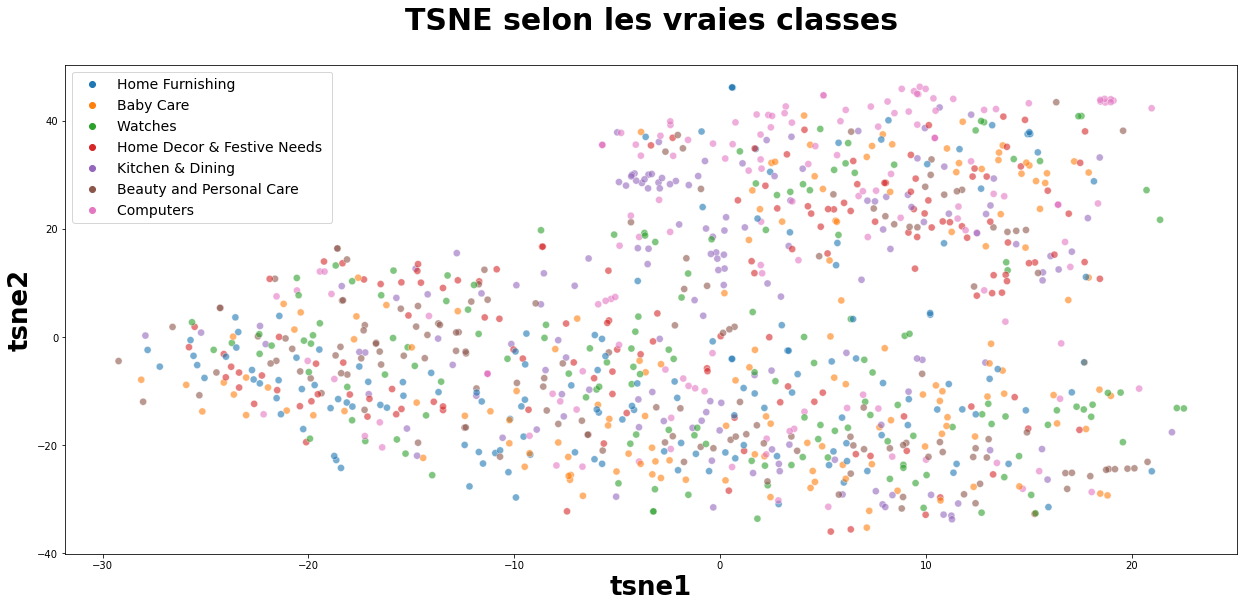

In [43]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

##  <a name="C66">Analyse mesures : similarité entre catégories et clusters</a> 

###  Création de clusters à partir du T-SNE

In [44]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI reste faible

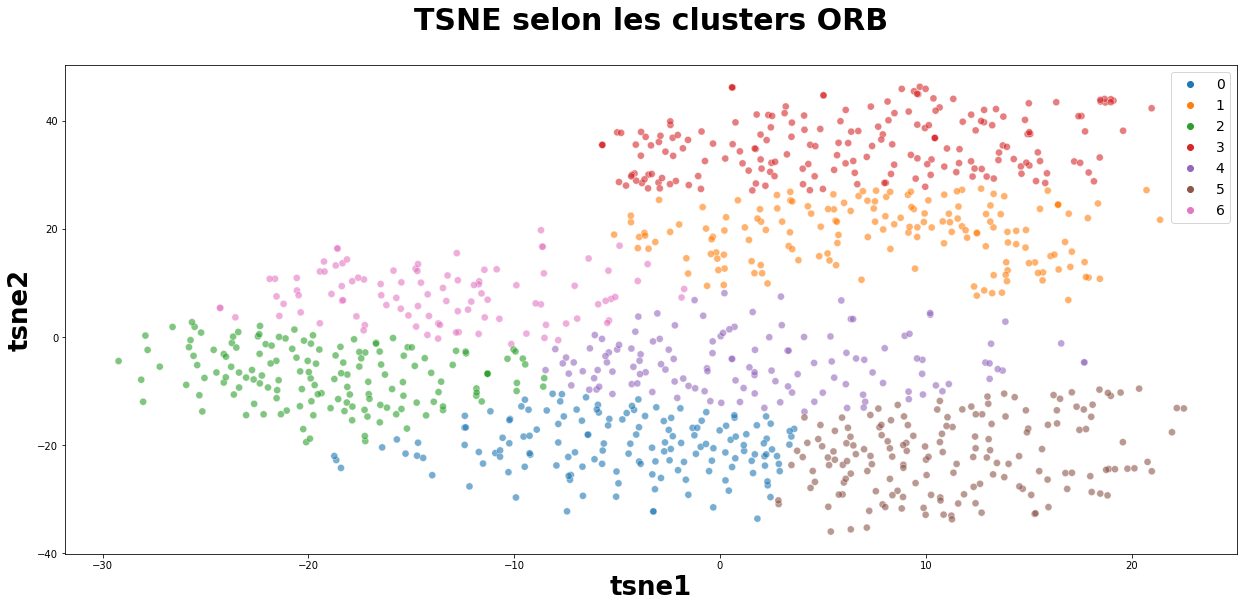

ARI ORB:  0.03411110058105214


In [45]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters ORB', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI ORB: ", metrics.adjusted_rand_score(labels, cls.labels_))

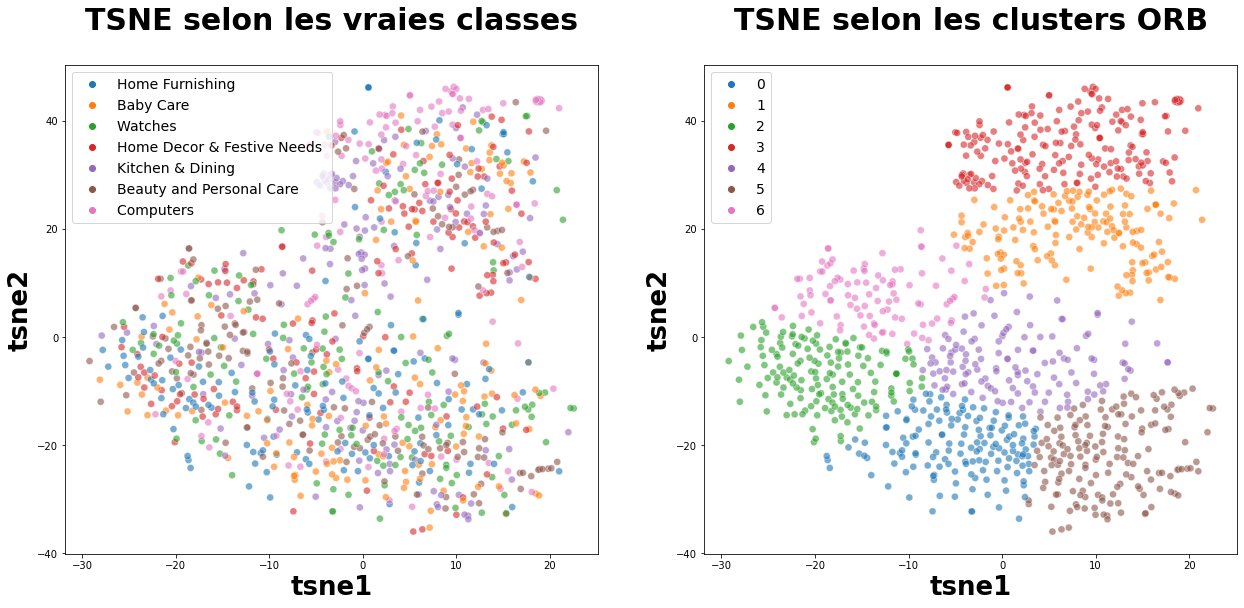

ARI ORB:  0.0341


In [46]:
plt.figure(figsize=(21,9))

plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters ORB', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI ORB: ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

# <a name="C7">CNN Transfert Learning</a>

---
<center>
    <img src="vision transfert learning models.png" width="700" alt="CV transfert models"  />
    <strong> number of parameters VS accuracy Computer Vision transfert learning models </strong>
</center>

## VGG16

In [47]:
# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# summarize the model
model.summary()

2022-07-17 08:40:50.917458: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-17 08:40:50.962191: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/houssein/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-17 08:40:50.962206: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-17 08:40:52.768028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRAR

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Pre-Trained Model as Classifier

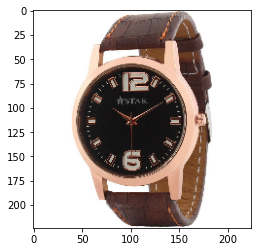

(1, 224, 224, 3)
1/1 [==============================] - 0s 338ms/step
analog_clock (71.32%)
Top 3 : [('n02708093', 'analog_clock', 0.71323293), ('n03706229', 'magnetic_compass', 0.082929805), ('n04548280', 'wall_clock', 0.07055903)]


In [48]:
# example of using a pre-trained model as a classifier
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
# load an image from file and convert the image size to 224x224 pixels
img = load_img(path+data['image'][data['image'].index==7].values[0])#, target_size=(224, 224))
img = resize_sq_fill_image(img)
plt.imshow(img)
plt.show()
# convert the image pixels to a numpy array
img = img_to_array(img)
# reshape data for the model
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
print(img.shape)
# prepare the image for the VGG model
img = preprocess_input(img)
# load the model
model = VGG16()
# predict the probability across all output classes
yhat = model.predict(img)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))
# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(yhat, top=3)[0])

### Pre-Trained Model as Feature Extractor Preprocessor

In [49]:
# example of using the vgg16 model as a feature extraction model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

# load an image from file and convert the image size to 224x224 pixels
img = load_img(path+data['image'][data['image'].index==502].values[0], target_size=(224, 224))
# convert the image pixels to a numpy array
img = img_to_array(img)
# reshape data for the model
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
# prepare the image for the VGG model
img = preprocess_input(img)
# load the model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# get extracted features
features = model.predict(img)
print(features.shape)

1/1 [==============================] - 0s 215ms/step
(1, 4096)


In [50]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [51]:
type(features[0])

numpy.ndarray

In [52]:
len(features.argsort()[0])

4096

# <a name="C8">Classification des images via CNN VGG16</a>

## Créations des Features de chaque image via CNN VGG16

* Pour chaque image resize en 224x224 pixel, passage en array et reshape en (1, 224, 224, 3)
* Extraction du dernier vecteur (1, 4096), avant le dernier étape du model VGG16: la classification (un vecteur à 1000 éléments)

In [53]:
# example of using the vgg16 model as a feature extraction model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# identification of key points and associated descriptors

descriptors = []
temps1=time.time()

# load the model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# get the feature vectors
data_set = {}
for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    # load an image from file and convert the image size to 224x224 pixels
    img = load_img(path+data['image'][data['image'].index==image_num].values[0], target_size=(224, 224))
    # convert the image pixels to a numpy array
    img = img_to_array(img)
    # reshape data for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # prepare the image for the VGG model
    img = preprocess_input(img)
    # get extracted features
    features = model.predict(img, verbose=0)
    data_set[data['image'][data['image'].index==image_num].values[0]]=features


# get a list of the filenames
filenames = np.array(list(data_set.keys()))

# get a list of just the features
feat = np.array(list(data_set.values()))

# reshape so that there are 1050 samples of 4096 vectors
feat = feat.reshape(-1,4096)

    

print()
print("Number of features : ", feat.shape)

duration1=time.time()-temps1
print("treatment times for VGG16 features extraction : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Number of features :  (1050, 4096)
treatment times for VGG16 features extraction :           197.27 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [54]:
# reduce the amount of dimensions in the feature vector

print("features dimensions before PCA : ", feat.shape)

#pca = PCA(n_components=70, random_state=22)
pca = decomposition.PCA(n_components=0.99, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

print("features dimensions after PCA : ", x.shape)

features dimensions before PCA :  (1050, 4096)
features dimensions after PCA :  (1050, 803)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [55]:
%%time
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(x)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category"]
print(df_tsne.shape)


(1050, 3)
CPU times: user 1min 17s, sys: 615 ms, total: 1min 18s
Wall time: 5 s


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

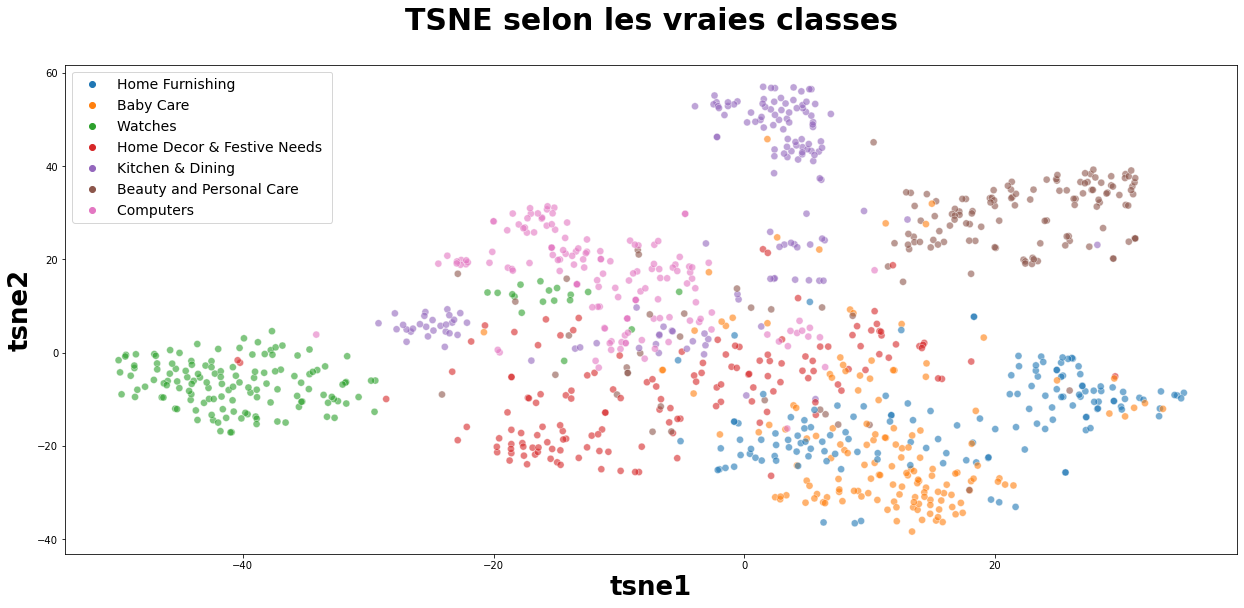

In [56]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [57]:

cls = KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

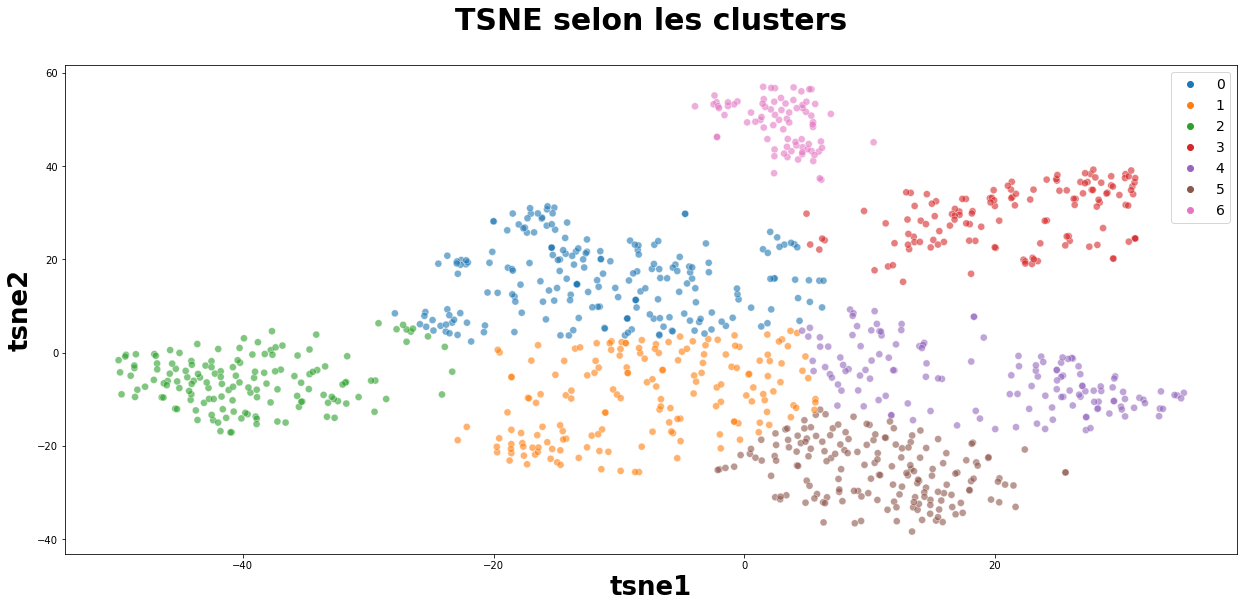

ARI :  0.4658575813882574


In [58]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

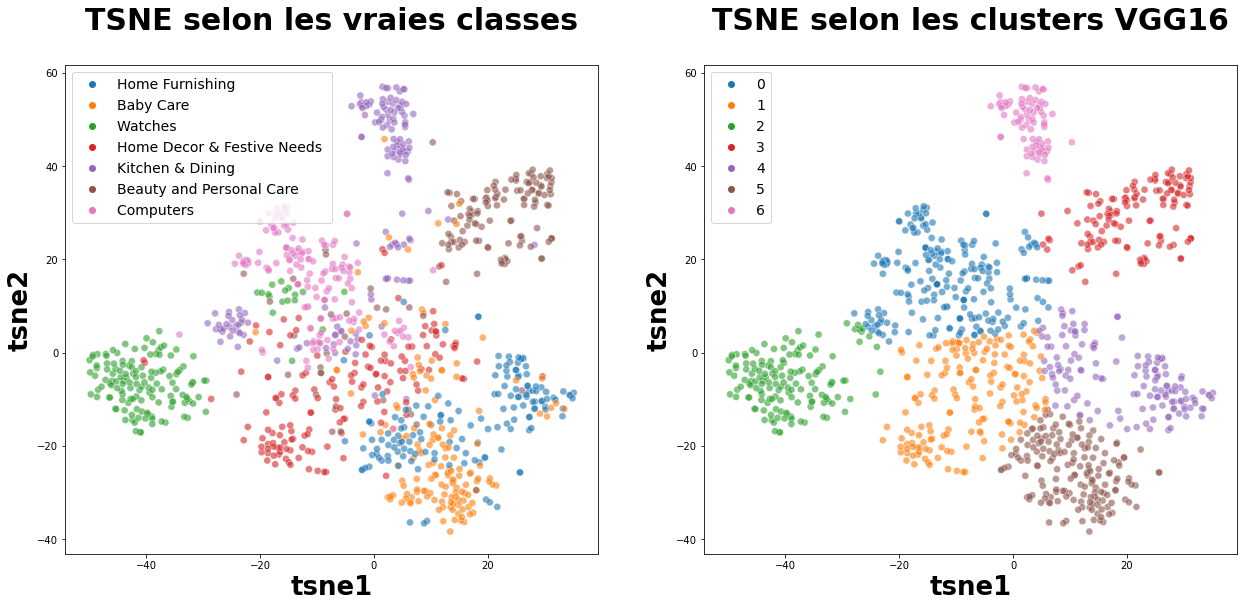

ARI VGG16 :  0.4659


In [59]:
plt.figure(figsize=(21,9))

plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters VGG16', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI VGG16 : ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

In [60]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,cls.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [61]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(path+file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 170 to 30


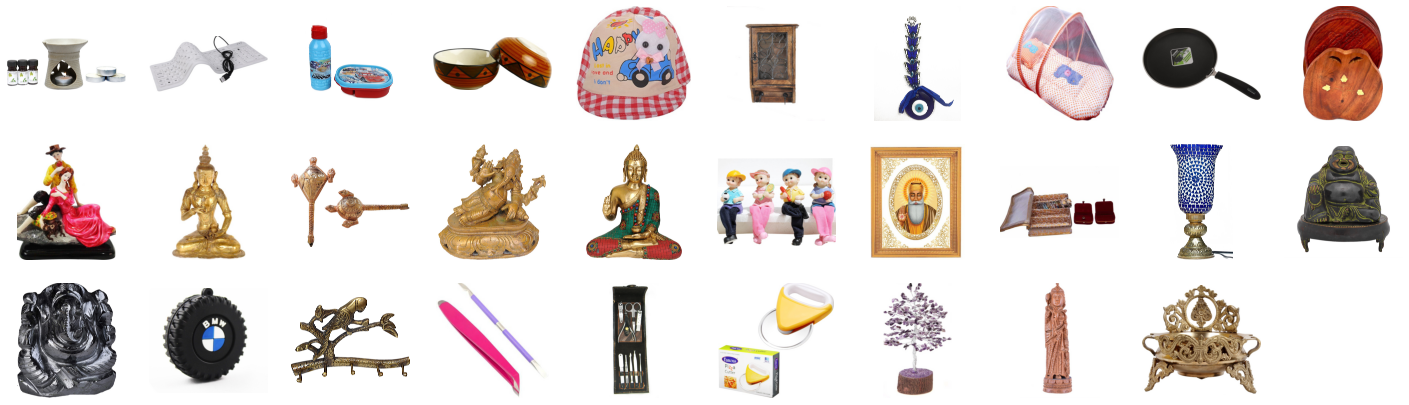

In [62]:
view_cluster(1)

# <a name="C81">Classification des images via CNN VGG19</a>

---
## VGG19

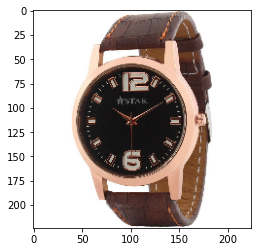

1/1 [==============================] - 0s 260ms/step
analog_clock (52.44%)
Top 3 : [('n02708093', 'analog_clock', 0.52440524), ('n03197337', 'digital_watch', 0.26745176), ('n04328186', 'stopwatch', 0.08124754)]


In [63]:
# example of loading the VGG19 model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

# load model
model = VGG19()

# load an image from file and convert the image size to 224x224 pixels
img_path = path+data['image'][data['image'].index==7].values[0]
img = image.load_img(img_path)#, target_size=(224, 224))
img = resize_sq_fill_image(img)
# show image
plt.imshow(img)
plt.show()
# convert the image pixels to a numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
# predict the probability across all output classes
preds = model.predict(x)
# convert the probabilities to class labels
label = decode_predictions(preds)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))
# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(preds, top=3)[0])

## Créations des Features de chaque image via CNN VGG19

* Pour chaque image resize en 224x224 pixel, passage en array et reshape en (1, 224, 224, 3)
* Extraction du dernier vecteur (1, 4096), avant le dernier étape du model VGG16: la classification (un vecteur à 1000 éléments)

In [64]:
# example of using the vgg16 model as a feature extraction model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# identification of key points and associated descriptors

descriptors = []
temps1=time.time()

# load the model
model = VGG19()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# get the feature vectors
data_set = {}
for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    # load an image from file and convert the image size to 224x224 pixels
    img_path = path+data['image'][data['image'].index==image_num].values[0]
    img = image.load_img(img_path)#, target_size=(224, 224))
    img = resize_sq_fill_image(img)

    # convert the image pixels to a numpy array
    img = img_to_array(img)
    # reshape data for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # prepare the image for the VGG model
    img = preprocess_input(img)
    # get extracted features
    features = model.predict(img, verbose=0)
    data_set[data['image'][data['image'].index==image_num].values[0]]=features


# get a list of the filenames
filenames = np.array(list(data_set.keys()))

# get a list of just the features
feat = np.array(list(data_set.values()))

# reshape so that there are 1050 samples of 4096 vectors
feat = feat.reshape(-1,4096)

    

print()
print("Number of features : ", feat.shape)

duration1=time.time()-temps1
print("treatment times for VGG19 features extraction : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Number of features :  (1050, 4096)
treatment times for VGG19 features extraction :           235.81 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [65]:
# reduce the amount of dimensions in the feature vector

print("features dimensions before PCA : ", feat.shape)

#pca = PCA(n_components=70, random_state=22)
pca = decomposition.PCA(n_components=0.99, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

print("features dimensions after PCA : ", x.shape)

features dimensions before PCA :  (1050, 4096)
features dimensions after PCA :  (1050, 779)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [66]:
%%time
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(x)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category"]
print(df_tsne.shape)

(1050, 3)
CPU times: user 1min 16s, sys: 623 ms, total: 1min 17s
Wall time: 4.87 s


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

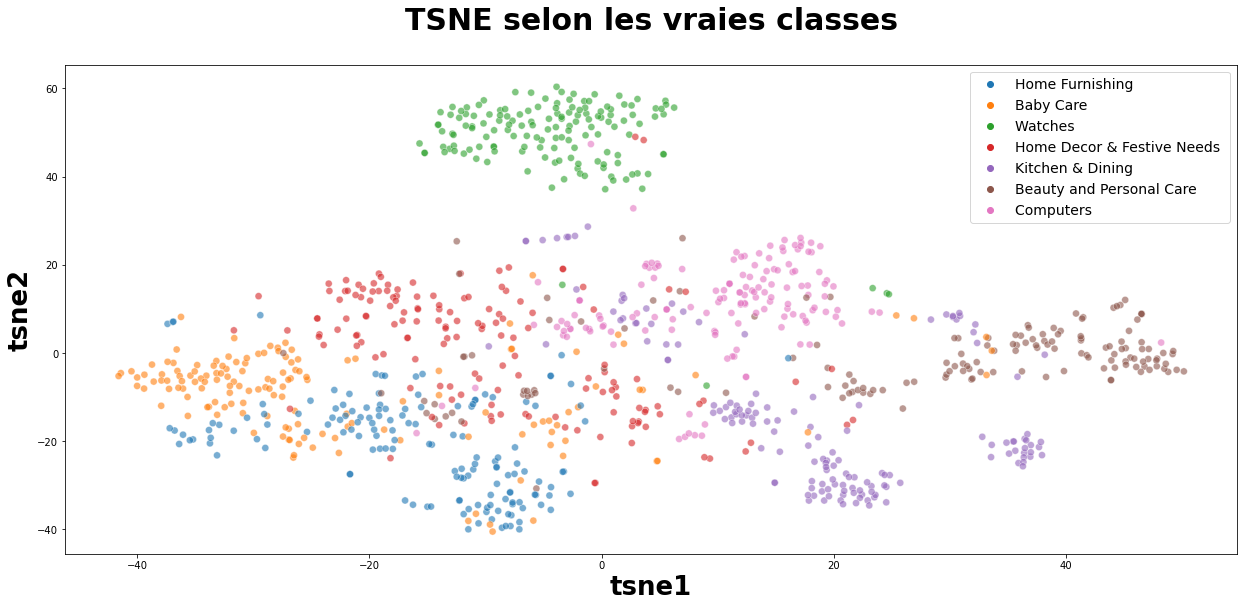

In [67]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [68]:

cls = KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

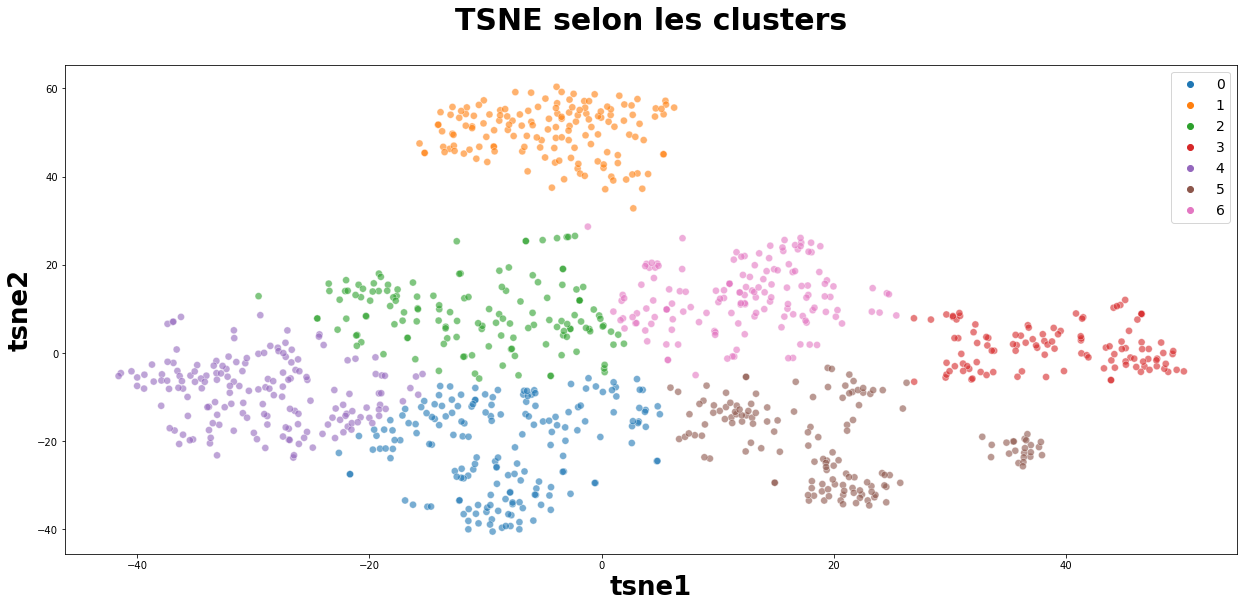

ARI :  0.4882940466150147


In [69]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

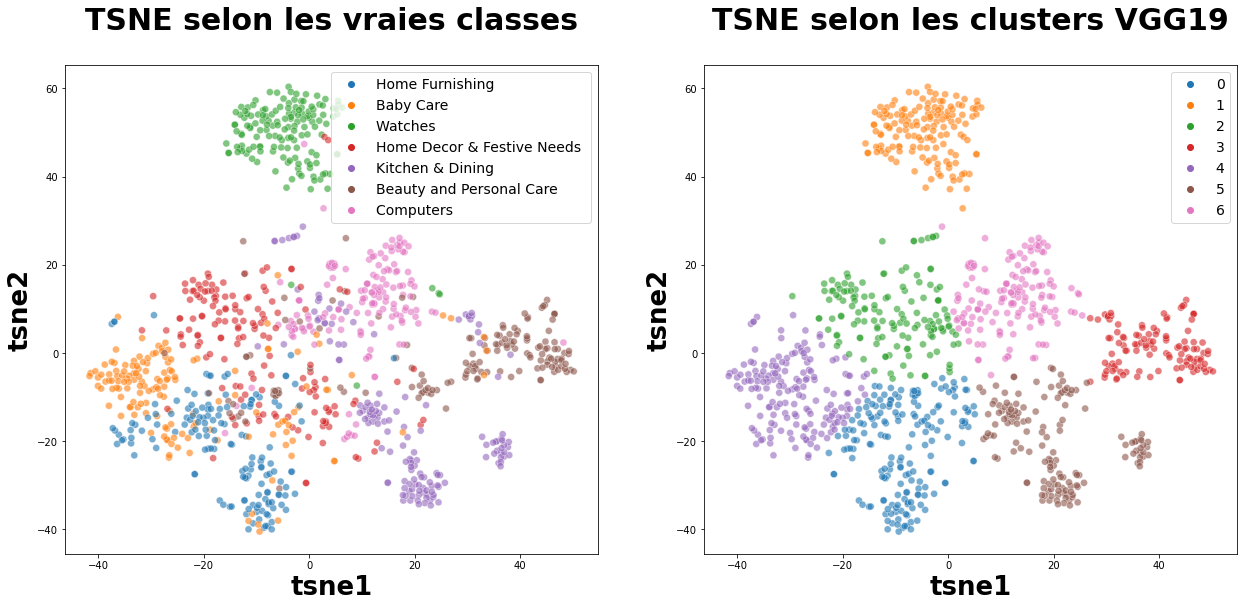

ARI VGG19 :  0.4883


In [70]:
plt.figure(figsize=(21,9))

plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters VGG19', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI VGG19 : ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

# <a name="C9">Classification des images via CNN ResNet50</a>

---
## ResNet50

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

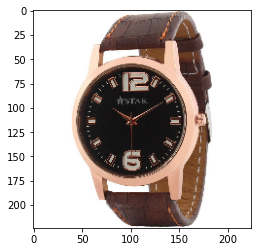

1/1 [==============================] - 1s 667ms/step
stopwatch (63.65%)
Top 3 : [('n04328186', 'stopwatch', 0.63647497), ('n02708093', 'analog_clock', 0.24227011), ('n04548280', 'wall_clock', 0.103592485)]


In [71]:
# example of loading the ResNet50 model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

# load model
model = ResNet50(weights='imagenet')

# summarize the model
model.summary()

# load an image from file and convert the image size to 224x224 pixels
img_path = path+data['image'][data['image'].index==7].values[0]
img = image.load_img(img_path)#, target_size=(224, 224))
img = resize_sq_fill_image(img)
# show image
plt.imshow(img)
plt.show()
# convert the image pixels to a numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
# predict the probability across all output classes
preds = model.predict(x)
# convert the probabilities to class labels
label = decode_predictions(preds)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))
# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(preds, top=3)[0])

## Créations des Features de chaque image via CNN ResNet50

* Pour chaque image resize en 224x224 pixel, passage en array et reshape en (1, 224, 224, 3)
* Extraction du dernier vecteur (1, 2048), avant le dernier étape du model VGG16: la classification (un vecteur à 1000 éléments)

In [72]:
# example of using the ResNet50 model as a feature extraction model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model

from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# identification of key points and associated descriptors

descriptors = []
temps1=time.time()

# load the model
model = ResNet50(weights='imagenet')

# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# get the feature vectors
data_set = {}
for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    # load an image from file and convert the image size to 224x224 pixels
    img_path = path+data['image'][data['image'].index==image_num].values[0]
    img = image.load_img(img_path)#, target_size=(224, 224))
    img = resize_sq_fill_image(img)

    # convert the image pixels to a numpy array
    img = img_to_array(img)
    # reshape data for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # prepare the image for the VGG model
    img = preprocess_input(img)
    # get extracted features
    features = model.predict(img, verbose=0)
    data_set[data['image'][data['image'].index==image_num].values[0]]=features


# get a list of the filenames
filenames = np.array(list(data_set.keys()))
print(filenames.shape)
# get a list of just the features
feat = np.array(list(data_set.values()))
print(feat.shape)
# reshape so that there are 1050 samples of 4096 vectors
feat = feat.reshape(-1,2048)
print(feat.shape)

    

print()
print("Number of features : ", feat.shape)

duration1=time.time()-temps1
print("treatment times for ResNet50 features extraction : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
(1050,)
(1050, 1, 2048)
(1050, 2048)

Number of features :  (1050, 2048)
treatment times for ResNet50 features extraction :           122.25 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [73]:
# reduce the amount of dimensions in the feature vector

print("features dimensions before PCA : ", feat.shape)

#pca = PCA(n_components=70, random_state=22)
pca = decomposition.PCA(n_components=0.99, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

print("features dimensions after PCA : ", x.shape)

features dimensions before PCA :  (1050, 2048)
features dimensions after PCA :  (1050, 707)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [74]:
%%time
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(x)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category"]
print(df_tsne.shape)

(1050, 3)
CPU times: user 1min 15s, sys: 569 ms, total: 1min 16s
Wall time: 4.84 s


## Analyse visuelle : affichage T-SNE selon catégories d'images
* Les catégories "cloudy" et "rain" sont partiellement séparées

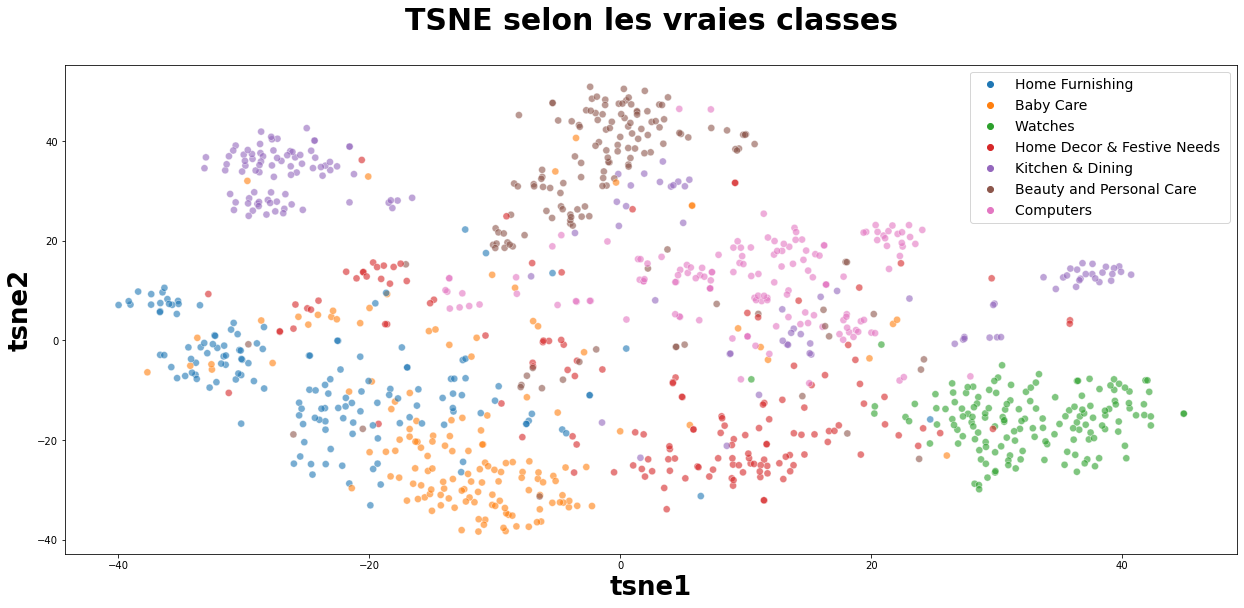

In [75]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [76]:

cls = KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

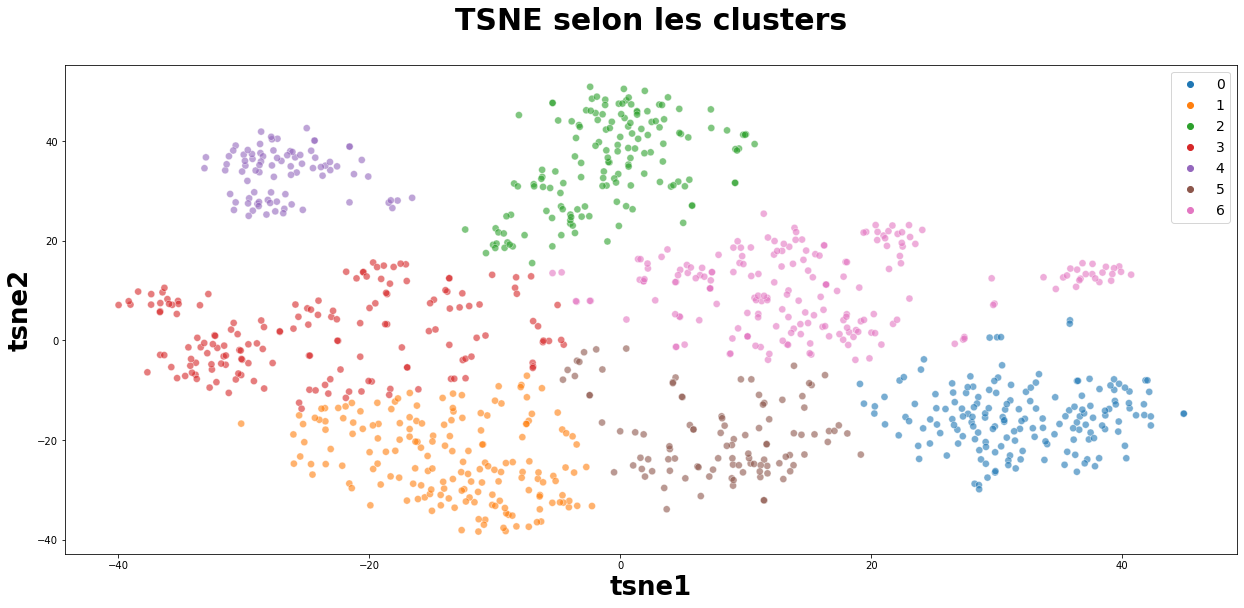

ARI :  0.49541827776567654


In [77]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

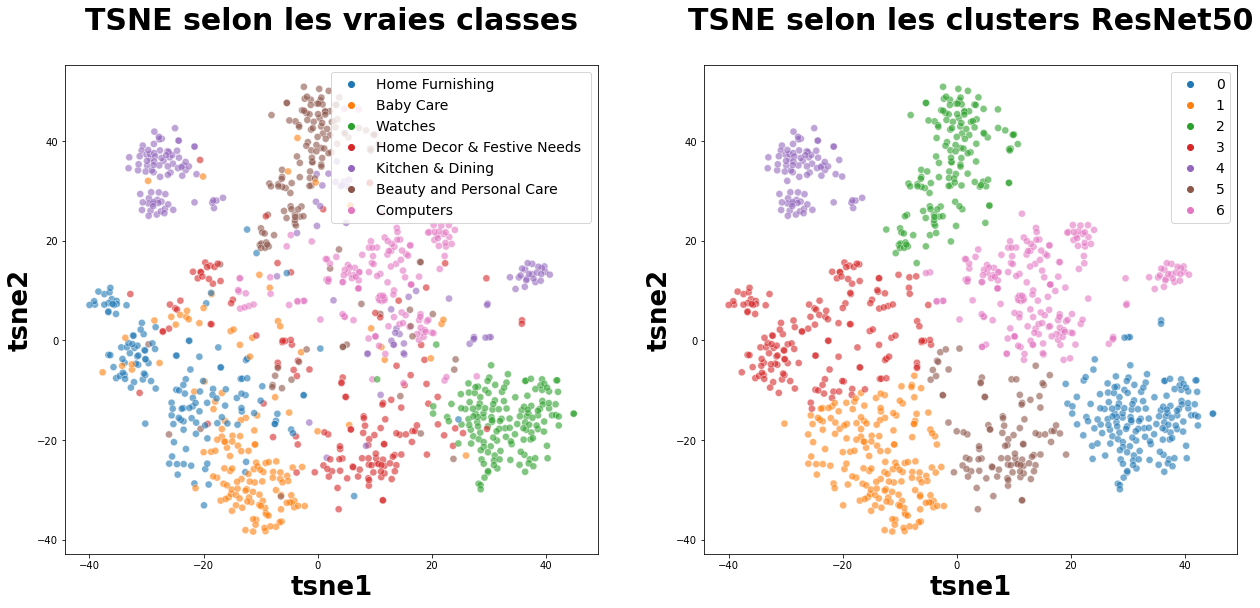

ARI ResNet50 :  0.4954


In [78]:
plt.figure(figsize=(21,9))

plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters ResNet50', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI ResNet50 : ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

# <a name="C10">Classification des images via CNN InceptionV3</a>

---
## InceptionV3

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

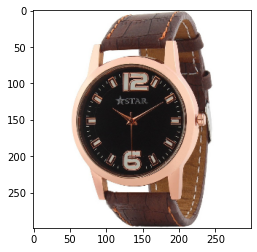

1/1 [==============================] - 1s 871ms/step
web_site (100.00%)
Top 3 : [('n06359193', 'web_site', 0.9999771), ('n02089973', 'English_foxhound', 1.6779612e-05), ('n04286575', 'spotlight', 6.059117e-06)]


In [79]:
# example of loading the inception v3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
# summarize the model
model.summary()

# load an image from file and convert the image size to 224x224 pixels
img_path = path+data['image'][data['image'].index==7].values[0]
img = image.load_img(img_path)#, target_size=(299, 299))
img = resize_sq_fill_image(img, sq_size=299)
# show image
plt.imshow(img)
plt.show()
# convert the image pixels to a numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
# predict the probability across all output classes
preds = model.predict(x)
# convert the probabilities to class labels
label = decode_predictions(preds)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))
# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(preds, top=3)[0])

## Créations des Features de chaque image via CNN InceptionV3

* Pour chaque image resize en 224x224 pixel, passage en array et reshape en (1, 224, 224, 3)
* Extraction du dernier vecteur (1, 2048), avant le dernier étape du model VGG16: la classification (un vecteur à 1000 éléments)

In [80]:
# example of using the InceptionV3 model as a feature extraction model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# identification of key points and associated descriptors

descriptors = []
temps1=time.time()

# load the model
model = InceptionV3()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# get the feature vectors
data_set = {}
for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    # load an image from file and convert the image size to 299x299 pixels
    img_path = path+data['image'][data['image'].index==image_num].values[0]
    img = image.load_img(img_path)#, target_size=(299, 299))
    img = resize_sq_fill_image(img, sq_size=299)

    # convert the image pixels to a numpy array
    img = img_to_array(img)
    # reshape data for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # prepare the image for the VGG model
    img = preprocess_input(img)
    # get extracted features
    features = model.predict(img, verbose=0)
    data_set[data['image'][data['image'].index==image_num].values[0]]=features


# get a list of the filenames
filenames = np.array(list(data_set.keys()))

# get a list of just the features
feat = np.array(list(data_set.values()))

# reshape so that there are 1050 samples of 4096 vectors
feat = feat.reshape(-1,2048)

    

print()
print("Number of features : ", feat.shape)

duration1=time.time()-temps1
print("treatment times for InceptionV3 features extraction : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Number of features :  (1050, 2048)
treatment times for InceptionV3 features extraction :           119.98 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [81]:
# reduce the amount of dimensions in the feature vector

print("features dimensions before PCA : ", feat.shape)

#pca = PCA(n_components=70, random_state=22)
pca = decomposition.PCA(n_components=0.99, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

print("features dimensions after PCA : ", x.shape)

features dimensions before PCA :  (1050, 2048)
features dimensions after PCA :  (1050, 688)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [82]:
%%time
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(x)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category"]
print(df_tsne.shape)

(1050, 3)
CPU times: user 1min 12s, sys: 591 ms, total: 1min 13s
Wall time: 4.7 s


## Analyse visuelle : affichage T-SNE selon catégories d'images

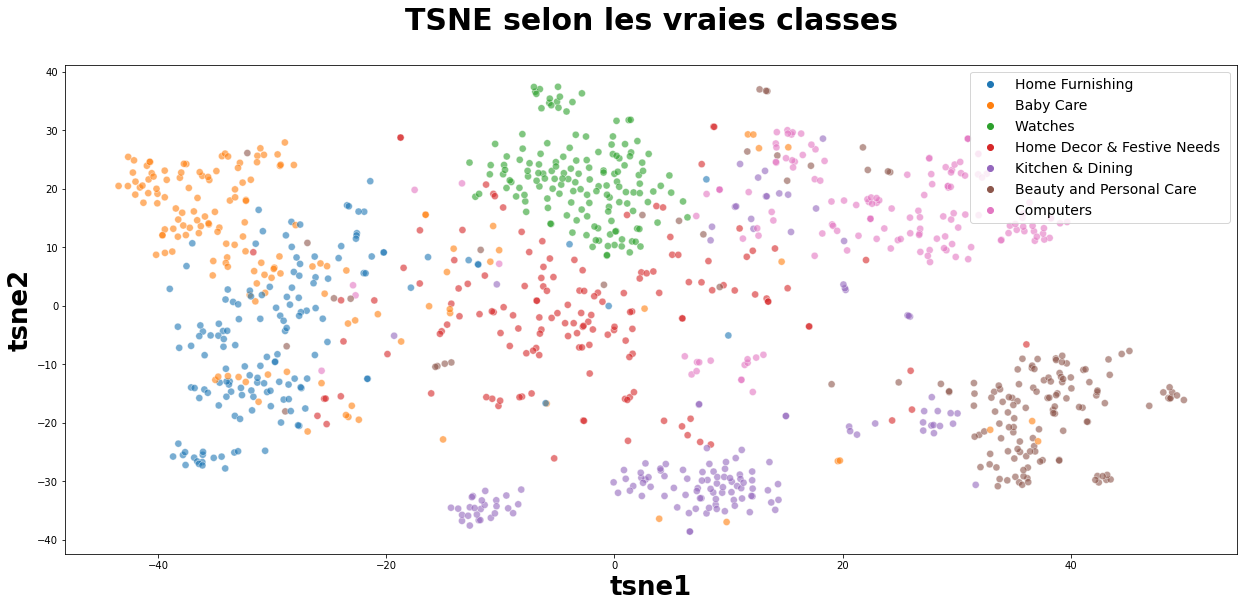

In [83]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [84]:

cls = KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

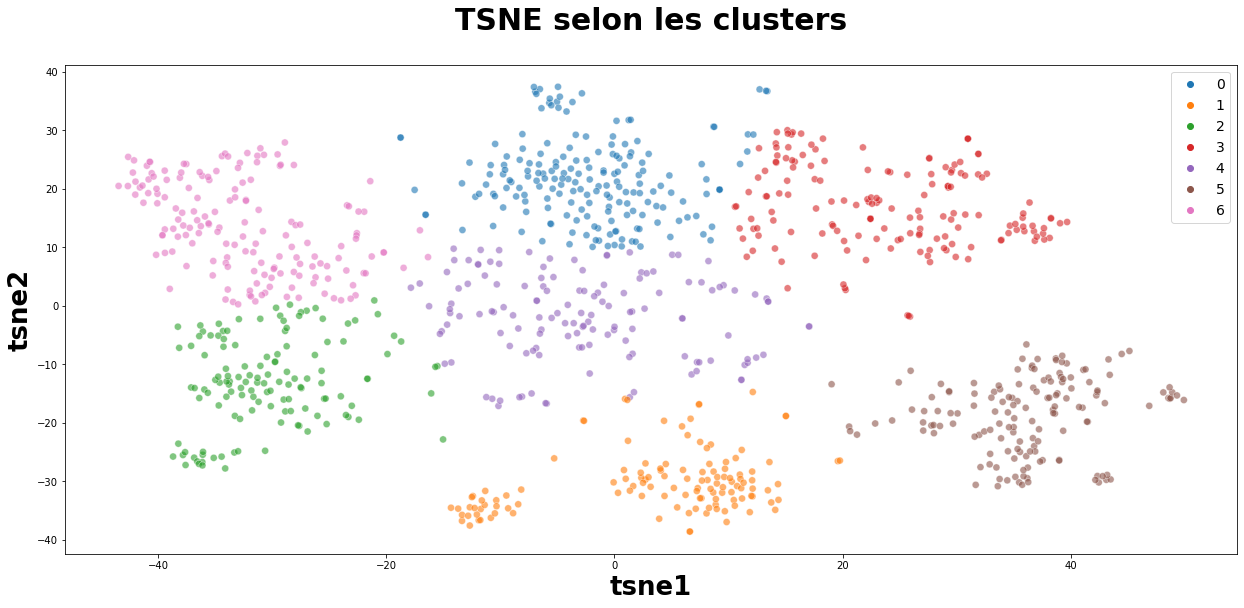

ARI :  0.5550688926235957


In [85]:
plt.figure(figsize=(21,9))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

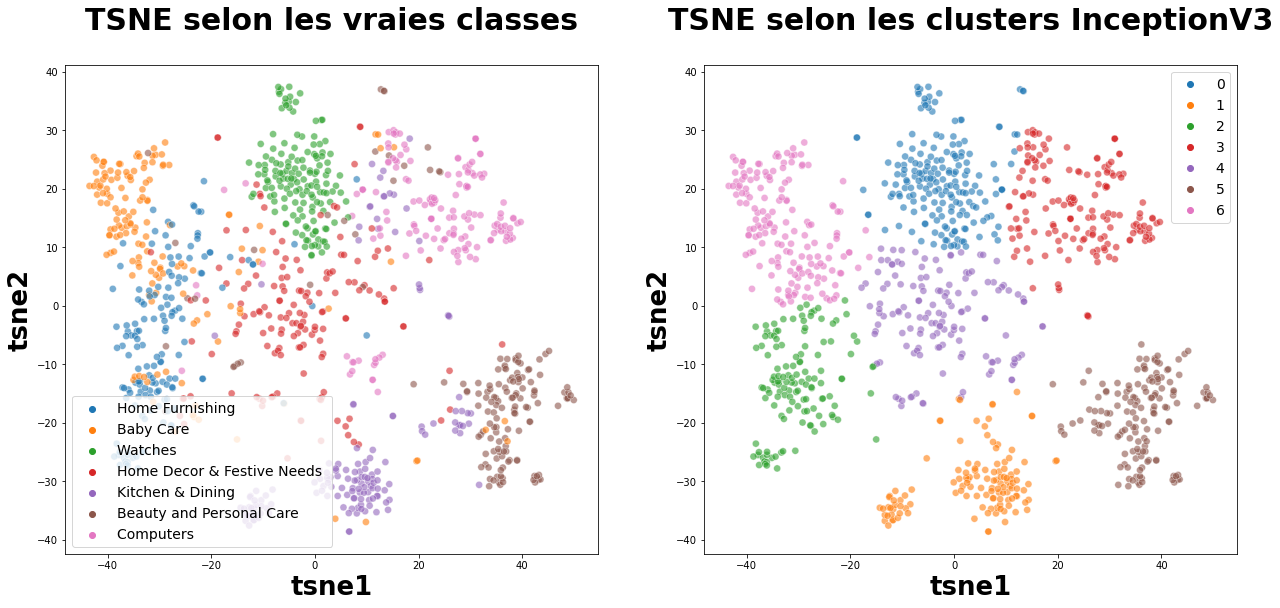

ARI InceptionV3 :  0.5551


In [86]:
plt.figure(figsize=(21,9))

plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters InceptionV3', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI InceptionV3 : ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

# Fin